# 1. Download/Load SP500 stocks prices data.

In [1]:
!pip install statsmodels
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install pandas-datareader
!pip install yfinance
!pip install datetime
!pip install scikit-learn
!pip install PyPortfolioOpt
!pip install pandas-ta

In [2]:
# Reinstalar pandas-ta con una versión específica compatible con numpy
!pip uninstall -y pandas-ta
!pip install pandas-ta==0.3.14b0

Found existing installation: pandas_ta 0.3.14b0
Uninstalling pandas_ta-0.3.14b0:
  Successfully uninstalled pandas_ta-0.3.14b0
  Using cached pandas_ta-0.3.14b0-py3-none-any.whl


In [3]:
# Corregir el error de importación en pandas-ta
import os
import site

# Buscar el archivo directamente en site-packages
site_packages = site.getsitepackages()[0]
squeeze_pro_path = os.path.join(site_packages, 'pandas_ta', 'momentum', 'squeeze_pro.py')

# Verificar si el archivo existe
if os.path.exists(squeeze_pro_path):
    print(f"Archivo encontrado en: {squeeze_pro_path}")
    
    # Leer el contenido actual
    with open(squeeze_pro_path, 'r') as file:
        content = file.read()
    
    # Reemplazar 'from numpy import NaN as npNaN' por 'from numpy import nan as npNaN'
    if 'from numpy import NaN as npNaN' in content:
        content = content.replace('from numpy import NaN as npNaN', 'from numpy import nan as npNaN')
        
        # Guardar el archivo modificado
        with open(squeeze_pro_path, 'w') as file:
            file.write(content)
        print("El archivo ha sido corregido correctamente.")
    else:
        print("El archivo ya ha sido corregido o tiene un formato diferente.")
else:
    print(f"Buscando archivo en: {site_packages}")
    
    # Buscar el archivo en todo el site-packages
    found = False
    for root, dirs, files in os.walk(site_packages):
        if 'squeeze_pro.py' in files:
            found_path = os.path.join(root, 'squeeze_pro.py')
            print(f"Archivo encontrado en ubicación alternativa: {found_path}")
            
            # Leer el contenido
            with open(found_path, 'r') as file:
                content = file.read()
            
            if 'from numpy import NaN as npNaN' in content:
                content = content.replace('from numpy import NaN as npNaN', 'from numpy import nan as npNaN')
                
                # Guardar el archivo modificado
                with open(found_path, 'w') as file:
                    file.write(content)
                print("El archivo ha sido corregido correctamente.")
                found = True
                break
            else:
                print("El archivo ya ha sido corregido o tiene un formato diferente.")
                found = True
                break
    
    if not found:
        print("No se pudo encontrar el archivo 'squeeze_pro.py' en ninguna ubicación.")


Buscando archivo en: c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv
Archivo encontrado en ubicación alternativa: c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\pandas_ta\momentum\squeeze_pro.py
El archivo ha sido corregido correctamente.


In [4]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

print(f"Número de símbolos: {len(symbols_list)}")
print(f"Primeros 10 símbolos: {symbols_list[:10]}")

end_date = '2025-05-14'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

print(f"\nDescargando datos desde {start_date} hasta {end_date}")

# Descargar los datos con parámetros específicos para preservar todas las columnas
df_raw = yf.download(tickers=symbols_list,
                     start=start_date,
                     end=end_date,
                     auto_adjust=False,  # Importante: no ajustar automáticamente
                     prepost=True,
                     threads=True)

print(f"\nForma de df_raw: {df_raw.shape}")
print(f"Columnas de df_raw: {df_raw.columns.tolist()}")

# Verificar si tenemos datos
if df_raw.empty:
    print("¡ERROR: No se pudieron descargar datos!")
else:
    # Reorganizar el DataFrame correctamente
    df = df_raw.stack(level=1)  # Stack el nivel de los tickers
    df.index.names = ['date', 'ticker']
    
    # Convertir nombres de columnas a minúsculas
    df.columns = df.columns.str.lower()
    
    print(f"\nForma de df después de stack: {df.shape}")
    print(f"Columnas de df: {df.columns.tolist()}")
    print(f"Nombres del índice: {df.index.names}")
    
    # Verificar que tenemos adj close
    if 'adj close' in df.columns:
        print("\n✓ Columna 'adj close' encontrada correctamente")
        print(f"Primeros valores de 'adj close':")
        print(df['adj close'].dropna().head())
    else:
        print("\n✗ Columna 'adj close' NO encontrada")
        print("Columnas disponibles:", df.columns.tolist())

df


Número de símbolos: 503
Primeros 10 símbolos: ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']

Descargando datos desde 2017-05-16 00:00:00 hasta 2025-05-14


[*********************100%***********************]  503 of 503 completed



Forma de df_raw: (2010, 3018)
Columnas de df_raw: [('Adj Close', 'A'), ('Adj Close', 'AAPL'), ('Adj Close', 'ABBV'), ('Adj Close', 'ABNB'), ('Adj Close', 'ABT'), ('Adj Close', 'ACGL'), ('Adj Close', 'ACN'), ('Adj Close', 'ADBE'), ('Adj Close', 'ADI'), ('Adj Close', 'ADM'), ('Adj Close', 'ADP'), ('Adj Close', 'ADSK'), ('Adj Close', 'AEE'), ('Adj Close', 'AEP'), ('Adj Close', 'AES'), ('Adj Close', 'AFL'), ('Adj Close', 'AIG'), ('Adj Close', 'AIZ'), ('Adj Close', 'AJG'), ('Adj Close', 'AKAM'), ('Adj Close', 'ALB'), ('Adj Close', 'ALGN'), ('Adj Close', 'ALL'), ('Adj Close', 'ALLE'), ('Adj Close', 'AMAT'), ('Adj Close', 'AMCR'), ('Adj Close', 'AMD'), ('Adj Close', 'AME'), ('Adj Close', 'AMGN'), ('Adj Close', 'AMP'), ('Adj Close', 'AMT'), ('Adj Close', 'AMZN'), ('Adj Close', 'ANET'), ('Adj Close', 'ANSS'), ('Adj Close', 'AON'), ('Adj Close', 'AOS'), ('Adj Close', 'APA'), ('Adj Close', 'APD'), ('Adj Close', 'APH'), ('Adj Close', 'APO'), ('Adj Close', 'APTV'), ('Adj Close', 'ARE'), ('Adj Clos

Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-05-16 A        53.492157   56.830002   58.380001   56.450001   58.380001   
           AAPL     36.213554   38.867500   39.014999   38.680000   38.985001   
           ABBV     47.478657   66.849998   66.919998   66.330002   66.730003   
           ABT      37.904331   43.689999   44.590000   43.410000   44.590000   
           ACGL     30.206877   31.766666   31.863333   31.590000   31.790001   
...                       ...         ...         ...         ...         ...   
2025-05-13 XYL     126.930000  126.930000  127.709999  126.779999  127.180000   
           YUM     145.008682  145.720001  147.009995  144.809998  147.000000   
           ZBH      97.489998   97.489998   98.230003   96.360001   97.989998   
           ZBRA    302.380005  302.380005  305.290009  300.369995  300.750000   
           ZTS     160.410004  160.410004  162.910004  160.059998  160.720001   

Price                  volume  
date       ticker              
2017-05-16 A        1032600.0  
           AAPL    80194000.0  
           ABBV     6313500.0  
           ABT      7159300.0  
           ACGL      804600.0  
...                       ...  
2025-05-13 XYL      1327600.0  
           YUM      1880000.0  
           ZBH      2324000.0  
           ZBRA      846800.0  
           ZTS      3336700.0  

[990380 rows x 6 columns]

# 2. Calculate features and technical indicators for each stock.
- Garman-Klass Volatility
- RSI
- Bollinger Bands
- ATR
- MACD
- Dollar Volume

 \begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}
    

In [5]:
# Calcular Garman-Klass Volatility
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

# Calcular RSI
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

# Calcular Bollinger Bands
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

# Calcular ATR normalizado
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['adj close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

# Calcular MACD normalizado
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

# Calcular volumen en millones de dólares
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

# Mostrar el DataFrame con los indicadores calculados
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-05-16 A        53.492157   56.830002   58.380001   56.450001   58.380001   
           AAPL     36.213554   38.867500   39.014999   38.680000   38.985001   
           ABBV     47.478657   66.849998   66.919998   66.330002   66.730003   
           ABT      37.904331   43.689999   44.590000   43.410000   44.590000   
           ACGL     30.206877   31.766666   31.863333   31.590000   31.790001   
...                       ...         ...         ...         ...         ...   
2025-05-13 XYL     126.930000  126.930000  127.709999  126.779999  127.180000   
           YUM     145.008682  145.720001  147.009995  144.809998  147.000000   
           ZBH      97.489998   97.489998   98.230003   96.360001   97.989998   
           ZBRA    302.380005  302.380005  305.290009  300.369995  300.750000   
           ZTS     160.410004  160.410004  162.910004  160.059998  160.720001   

Price                  volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-05-16 A        1032600.0         -0.002388        NaN       NaN   
           AAPL    80194000.0         -0.002064        NaN       NaN   
           ABBV     6313500.0         -0.044715        NaN       NaN   
           ABT      7159300.0         -0.009834        NaN       NaN   
           ACGL      804600.0         -0.000971        NaN       NaN   
...                       ...               ...        ...       ...   
2025-05-13 XYL      1327600.0          0.000025  61.794912  4.678320   
           YUM      1880000.0          0.000042  45.965012  4.957244   
           ZBH      2324000.0          0.000175  44.094881  4.524274   
           ZBRA      846800.0          0.000121  63.240049  5.357481   
           ZTS      3336700.0          0.000154  53.479526  4.982374   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2017-05-16 A            NaN       NaN       NaN       NaN      55.236001  
           AAPL         NaN       NaN       NaN       NaN    2904.109780  
           ABBV         NaN       NaN       NaN       NaN     299.756500  
           ABT          NaN       NaN       NaN       NaN     271.368478  
           ACGL         NaN       NaN       NaN       NaN      24.304453  
...                     ...       ...       ...       ...            ...  
2025-05-13 XYL     4.777212  4.876105 -1.323269  1.367672     168.512268  
           YUM     4.989772  5.022299 -1.865657 -0.602271     272.616323  
           ZBH     4.595950  4.667626 -1.120585 -0.988090     226.566755  
           ZBRA    5.522473  5.687466  0.929265  0.755502     256.055388  
           ZTS     5.043721  5.105067 -0.784831  0.327079     535.240059  

[990380 rows x 14 columns]

# 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.
- To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [6]:
last_cols = [c for c in df.columns.unique(0) if c not in ['open', 'high', 'low', 'close', 'volume','dollar_volume']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                    df.unstack()[last_cols].resample('M').last().stack('ticker')],
                   axis=1)).dropna()

data
#df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-06-30 A          109.548806   55.950832         -0.001012  53.174493   
           AAPL      4268.541457   33.546513         -0.002065  38.245906   
           ABBV       298.847267   51.498543         -0.045411  73.664075   
           ABT        302.877910   42.172787         -0.008142  70.961749   
           ACGL        69.558512   29.569775         -0.001103  42.661682   
...                          ...         ...               ...        ...   
2025-05-31 XYL        175.917955  126.930000          0.000025  61.794912   
           YUM        268.608580  145.008682          0.000042  45.965012   
           ZBH        321.604173   97.489998          0.000175  44.094881   
           ZBRA       206.729977  302.380005          0.000121  63.240049   
           ZTS        590.935495  160.410004          0.000154  53.479526   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2017-06-30 A       4.027342  4.046235  4.065128 -0.308419  0.007962  
           AAPL    3.511176  3.563069  3.614962 -1.023575 -0.501340  
           ABBV    3.890018  3.937576  3.985134  0.679390  0.411809  
           ABT     3.715288  3.752833  3.790378 -0.115991  0.607718  
           ACGL    3.402675  3.430145  3.457615 -0.875012 -0.450039  
...                     ...       ...       ...       ...       ...  
2025-05-31 XYL     4.678320  4.777212  4.876105 -1.323269  1.367672  
           YUM     4.957244  4.989772  5.022299 -1.865657 -0.602271  
           ZBH     4.524274  4.595950  4.667626 -1.120585 -0.988090  
           ZBRA    5.357481  5.522473  5.687466  0.929265  0.755502  
           ZTS     4.982374  5.043721  5.105067 -0.784831  0.327079  

[47298 rows x 9 columns]

- Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [7]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-05-31 AAPL     44.204174         -0.001200  59.945479  3.779782   
           ABBV     72.653076         -0.041405  46.193220  4.288175   
           ABT      54.458664         -0.006269  54.184920  3.961811   
           ACN     140.315750         -0.004265  53.108578  4.925236   
           ADBE    249.279999          0.000167  67.105803  5.431916   
...                       ...               ...        ...       ...   
2025-05-31 VZ       42.650002          0.000075  47.657027  3.762462   
           WDAY    270.019989          0.000093  66.035757  5.368577   
           WFC      75.989998          0.000205  62.935699  4.151715   
           WMT      95.879997          0.000220  54.534919  4.527725   
           XOM     108.461052          0.000068  52.842848  4.633090   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2018-05-31 AAPL    3.809634  3.839485 -0.917050  0.088349  
           ABBV    4.337685  4.387196  1.791506  0.018223  
           ABT     4.004612  4.047413  0.196903  0.207943  
           ACN     4.944963  4.964690  0.226594 -0.002852  
           ADBE    5.480050  5.528185 -1.184392  0.460818  
...                     ...       ...       ...       ...  
2025-05-31 VZ      3.791511  3.820560 -1.781915 -0.010364  
           WDAY    5.491662  5.614747  0.514480  1.479676  
           WFC     4.260194  4.368673 -0.993850  1.680193  
           WMT     4.572275  4.616824 -0.575134  2.048463  
           XOM     4.669005  4.704921 -1.357163 -0.390327  

[12665 rows x 8 columns]

# 4. Calculate Monthly Returns for different time horizons as features.
- To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [8]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2019-05-31 AAPL     42.043262         -0.000701  34.632816  3.729628   
           ABBV     58.990623         -0.028138  40.509277  4.087179   
           ABT      68.556511         -0.004000  47.744543  4.223157   
           ACN     163.241531         -0.002625  54.904675  5.066404   
           ADBE    270.899994          0.000117  47.431756  5.595761   
...                       ...               ...        ...       ...   
2025-05-31 VZ       42.650002          0.000075  47.657027  3.762462   
           WDAY    270.019989          0.000093  66.035757  5.368577   
           WFC      75.989998          0.000205  62.935699  4.151715   
           WMT      95.879997          0.000220  54.534919  4.527725   
           XOM     108.461052          0.000068  52.842848  4.633090   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2019-05-31 AAPL    3.836748  3.943867 -1.451576 -0.780296  -0.124213   
           ABBV    4.120630  4.154081  0.355169 -0.345995  -0.033757   
           ABT     4.246252  4.269347  0.499783 -0.476092  -0.043112   
           ACN     5.093782  5.121161  0.066913  0.003359  -0.025182   
           ADBE    5.627233  5.658705 -0.977400 -0.102993  -0.063440   
...                     ...       ...       ...       ...        ...   
2025-05-31 VZ      3.791511  3.820560 -1.781915 -0.010364  -0.032002   
           WDAY    5.491662  5.614747  0.514480  1.479676   0.102122   
           WFC     4.260194  4.368673 -0.993850  1.680193   0.076002   
           WMT     4.572275  4.616824 -0.575134  2.048463  -0.011704   
           XOM     4.669005  4.704921 -1.357163 -0.390327   0.036259   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2019-05-31 AAPL    -0.038120   0.004969  -0.001953  -0.027496   -0.004168  
           ABBV    -0.017923  -0.006405  -0.029679  -0.020684   -0.017210  
           ABT     -0.022126  -0.005087   0.006087   0.016011    0.019370  
           ACN      0.009963   0.036194   0.014672   0.007720    0.012691  
           ADBE     0.008240   0.010555   0.012871   0.003078    0.006955  
...                      ...        ...        ...        ...         ...  
2025-05-31 VZ      -0.022576   0.001814  -0.000893   0.007763    0.008454  
           WDAY     0.075293   0.008385   0.012929   0.002851    0.020585  
           WFC      0.031655  -0.008209   0.001339   0.031397    0.022017  
           WMT      0.046323  -0.007610   0.007236   0.025165    0.032802  
           XOM     -0.040639  -0.005631  -0.010920  -0.006372   -0.003637  

[10470 rows x 14 columns]

# 5. Download Fama-French Factors and Calculate Rolling Factor Betas.
- We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

- The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

- We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [9]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-05-31 AAPL   -0.0692 -0.0156 -0.0245 -0.0048  0.0176  -0.124213
           ABBV   -0.0692 -0.0156 -0.0245 -0.0048  0.0176  -0.033757
           ABT    -0.0692 -0.0156 -0.0245 -0.0048  0.0176  -0.043112
           ACN    -0.0692 -0.0156 -0.0245 -0.0048  0.0176  -0.025182
           ADBE   -0.0692 -0.0156 -0.0245 -0.0048  0.0176  -0.063440
...                   ...     ...     ...     ...     ...        ...
2025-03-31 VZ     -0.0639 -0.0149  0.0291  0.0213 -0.0047   0.052436
           WDAY   -0.0639 -0.0149  0.0291  0.0213 -0.0047  -0.113200
           WFC    -0.0639 -0.0149  0.0291  0.0213 -0.0047  -0.083376
           WMT    -0.0639 -0.0149  0.0291  0.0213 -0.0047  -0.107280
           XOM    -0.0639 -0.0149  0.0291  0.0213 -0.0047   0.068266

[10191 rows x 6 columns]

- Filter out stocks with less than 10 months of data.

In [10]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-05-31 AAPL   -0.0692 -0.0156 -0.0245 -0.0048  0.0176  -0.124213
           ABBV   -0.0692 -0.0156 -0.0245 -0.0048  0.0176  -0.033757
           ABT    -0.0692 -0.0156 -0.0245 -0.0048  0.0176  -0.043112
           ACN    -0.0692 -0.0156 -0.0245 -0.0048  0.0176  -0.025182
           ADBE   -0.0692 -0.0156 -0.0245 -0.0048  0.0176  -0.063440
...                   ...     ...     ...     ...     ...        ...
2025-03-31 VZ     -0.0639 -0.0149  0.0291  0.0213 -0.0047   0.052436
           WDAY   -0.0639 -0.0149  0.0291  0.0213 -0.0047  -0.113200
           WFC    -0.0639 -0.0149  0.0291  0.0213 -0.0047  -0.083376
           WMT    -0.0639 -0.0149  0.0291  0.0213 -0.0047  -0.107280
           XOM    -0.0639 -0.0149  0.0291  0.0213 -0.0047   0.068266

[10126 rows x 6 columns]

- Calculate Rolling Factor Betas.

In [11]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2019-05-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-03-31 VZ      0.968694 -1.084182  1.037340  0.827954 -0.241693
           WDAY    1.031800 -0.982283  0.250989 -2.087325 -0.887111
           WFC     0.778693 -0.016219  0.162299 -1.881719  0.506471
           WMT     0.974651  0.037857 -0.395171  0.869167  0.302466
           XOM     0.432427 -0.246443  0.799231  1.099536  0.467882

[10126 rows x 5 columns]

- Join the rolling factors data to the main features dataframe.

In [12]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10214 entries, (Timestamp('2019-05-31 00:00:00'), 'AAPL') to (Timestamp('2025-05-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10214 non-null  float64
 1   rsi               10214 non-null  float64
 2   bb_low            10214 non-null  float64
 3   bb_mid            10214 non-null  float64
 4   bb_high           10214 non-null  float64
 5   atr               10214 non-null  float64
 6   macd              10214 non-null  float64
 7   return_1m         10214 non-null  float64
 8   return_2m         10214 non-null  float64
 9   return_3m         10214 non-null  float64
 10  return_6m         10214 non-null  float64
 11  return_9m         10214 non-null  float64
 12  return_12m        10214 non-null  float64
 13  Mkt-RF            10214 non-null  float64
 14  SMB               10214 non-null  float64
 15  HML       

### At this point we have to decide on what ML model and approach to use for predictions etc.
## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
### K-Means Clustering
- You may want to initialize predefined centroids for each cluster based on your research.

- For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

- Then we will pre-define our centroids for each cluster.

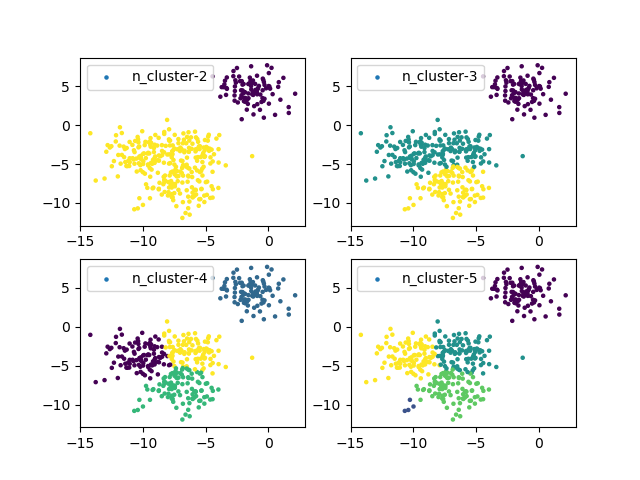

In [25]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2019-05-31 AAPL           -0.000701  34.632816  3.729628  3.836748  3.943867   
           ABBV           -0.028138  40.509277  4.087179  4.120630  4.154081   
           ABT            -0.004000  47.744543  4.223157  4.246252  4.269347   
           ACN            -0.002625  54.904675  5.066404  5.093782  5.121161   
           ADBE            0.000117  47.431756  5.595761  5.627233  5.658705   
...                             ...        ...       ...       ...       ...   
2025-05-31 VZ              0.000075  47.657027  3.762462  3.791511  3.820560   
           WDAY            0.000093  66.035757  5.368577  5.491662  5.614747   
           WFC             0.000205  62.935699  4.151715  4.260194  4.368673   
           WMT             0.000220  54.534919  4.527725  4.572275  4.616824   
           XOM             0.000068  52.842848  4.633090  4.669005  4.704921   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2019-05-31 AAPL   -1.451576 -0.780296  -0.124213  -0.038120   0.004969   
           ABBV    0.355169 -0.345995  -0.033757  -0.017923  -0.006405   
           ABT     0.499783 -0.476092  -0.043112  -0.022126  -0.005087   
           ACN     0.066913  0.003359  -0.025182   0.009963   0.036194   
           ADBE   -0.977400 -0.102993  -0.063440   0.008240   0.010555   
...                     ...       ...        ...        ...        ...   
2025-05-31 VZ     -1.781915 -0.010364  -0.032002  -0.022576   0.001814   
           WDAY    0.514480  1.479676   0.102122   0.075293   0.008385   
           WFC    -0.993850  1.680193   0.076002   0.031655  -0.008209   
           WMT    -0.575134  2.048463  -0.011704   0.046323  -0.007610   
           XOM    -1.357163 -0.390327   0.036259  -0.040639  -0.005631   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-05-31 AAPL    -0.001953  -0.027496   -0.004168  1.241762 -0.091725   
           ABBV    -0.029679  -0.020684   -0.017210  0.544508  0.159597   
           ABT      0.006087   0.016011    0.019370  0.781640 -0.046633   
           ACN      0.014672   0.007720    0.012691  1.162400 -0.181301   
           ADBE     0.012871   0.003078    0.006955  1.377014 -0.615795   
...                      ...        ...         ...       ...       ...   
2025-05-31 VZ      -0.000893   0.007763    0.008454  0.521610 -0.536200   
           WDAY     0.012929   0.002851    0.020585  1.163054 -0.635381   
           WFC      0.001339   0.031397    0.022017  1.079990 -0.159561   
           WMT      0.007236   0.025165    0.032802  0.663433 -0.295712   
           XOM     -0.010920  -0.006372   -0.003637  0.954851 -0.065124   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2019-05-31 AAPL   -0.688678  0.371846  0.412204        0  
           ABBV   -0.082435  0.296090  0.581140        3  
           ABT    -0.371990  0.087812  1.014484        2  
           ACN    -0.241813  0.249141 -0.029951        2  
           ADBE   -0.250568  0.296085 -0.415621        2  
...                     ...       ...       ...      ...  
2025-05-31 VZ      0.385961  0.156022  0.015713        3  
           WDAY   -0.318357 -0.951588 -0.464325        2  
           WFC     1.618781 -0.792944 -1.109368        2  
           WMT    -0.327359  0.248881  0.531929        1  
           XOM     0.932763 -0.385917  0.348994        3  

[10214 rows x 19 columns]

In [26]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

In [ ]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

### Apply pre-defined centroids.

In [18]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

### 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
- First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

- Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [ ]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates